In [1]:
%matplotlib inline

import cv2
import json
import tensorflow as tf
import numpy as np
import os
import sys
import re

from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# base = os.path.dirname(os.path.realpath(.model.path))

In [2]:
# labels = json.load(open('../data/label.json', 'r'))
# labels = [labels[str(idx)] for idx in labels]

In [3]:
img_path = '/var/ds/ocr/data/images'

labels = []
images = []
images_path = []

# for idx, label in enumerate(labels):
#     img_name = '{}_{}.jpg'.format(idx, label)
#     full_img_path = '{}/{}'.format(img_path, img_name)
    
#     if not os.path.isfile(full_img_path):
#         labels[idx] = None
#         continue

#     images_path.append(full_img_path)

for f in listdir(img_path):    
    path = join(img_path, f)
    
    if isfile(path) and 'jpg' in path:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

#     print('{}/{}'.format(img_path, img_name))
#         img = cv2.imread(join(img_path, f), cv2.IMREAD_GRAYSCALE)
#         plt.imshow(img, cmap='gray', vmin=0, vmax=255)

        img = np.asarray(img).astype(np.float32) / 255.
        img = img - 0.5
        images.append(img)

        label = re.match(r'.*[_](.*)\.jpg', f).group(1)
        labels.append(label)

945059691215


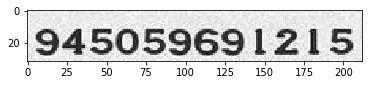

In [4]:
print(labels[500])
plt.imshow((images[500] + 0.5) * 255, cmap='gray', vmin=0, vmax=255)

In [5]:
# images = [(img / 255) - 0.5 for img in images]

In [6]:
# labels = [label for label in labels if label is not None]

In [7]:
def create_sparse(batch_size, images, labels, dtype=np.int64):
    indices = []
    values = []
    
    sample_index = np.random.choice(len(images) - 1, size=batch_size)
    sample_images = []
    
    x_max = 0
    y_max = 0

    for key, index in zip(sample_index, range(batch_size)):
        sample = labels[key]
        length = len(sample)
        label = sample
        
        img = images[key]
#         plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        x_max = max(x_max, img.shape[0])
        y_max = max(y_max, img.shape[1])

#         img = img / 255
        sample_images.append(img)

        for number, number_index in zip(label, range(length)):
            indices.append((index, number_index))
#             print(number, ord(str(number)), FIRST_INDEX, ord(str(number)) - FIRST_INDEX)
            values.append(ord(str(number)) - FIRST_INDEX)

    indices = np.array(indices, dtype=np.int64)
    values = np.array(values, dtype=dtype)
    shape = np.array([batch_size, np.asarray(indices).max(0)[1] + 1], dtype=np.int64)

    return indices, values, shape, sample_images, x_max, y_max

# create_sparse(n_batch_size, images, labels)

In [8]:
def add_padding_to_images(x_max, y_max, images):

    output = []
    for img in images:
        left_pad = int((x_max - img.shape[0]) / 2)
        right_pad = x_max - img.shape[0] - int((x_max - img.shape[0]) / 2)
        top_pad = int((y_max - img.shape[1]) / 2)
        bottom_pad = y_max - img.shape[1] - int((y_max - img.shape[1]) / 2)

        img = np.pad(img, 
                     pad_width=((left_pad, right_pad), 
                                (top_pad, bottom_pad)), 
                     mode='constant', 
                     constant_values=0)
        
        img = np.transpose(img.reshape((x_max, y_max)))
        output.append(img)
        
    return np.array(output)

In [9]:
FIRST_INDEX = ord(' ')
SPACE_TOKEN = '<space>'
SPACE_INDEX = 0

n_batch_size = 32
n_features = 32
n_rnn_layers = 1
n_filter = 64
n_hidden = 512
# n_classes = ord('z') - ord('a') + 10 + 1 + 1 + 1
n_classes = ord('~') - FIRST_INDEX + 1

n_epochs = 20000

learning_rate = 0.005

In [10]:
n_test_size = 0.3
n_test_index = int(len(images) * n_test_size)

train_images = images[:n_test_index]
test_images = images[n_test_index:]

train_labels = labels[:n_test_index]
test_labels = labels[n_test_index:]

In [11]:
tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():
    inputs = tf.placeholder(tf.float32, [None, None, n_features])
    targets = tf.sparse_placeholder(tf.int32)
    seq_len = tf.placeholder(tf.int32, None)
#     time_len = tf.placeholder(tf.int32, [None])
    
    w_init = tf.contrib.layers.variance_scaling_initializer()
    b_init = tf.constant_initializer(0.1)
    
    shape = tf.shape(inputs)
    
    x_expanded = tf.expand_dims(inputs, -1)
    
    with tf.variable_scope('conv1'):
        conv1 = tf.layers.conv2d(
            x_expanded,
            n_filter,
            kernel_size=(3, 3),
            padding='SAME',
            kernel_initializer=w_init,
            bias_initializer=b_init,
            activation=tf.nn.elu,
        )
        conv1 = tf.layers.max_pooling2d(
            conv1,
            (2, 2),            
            (2, 2),
            padding='SAME',
        )
        
    with tf.variable_scope('conv2'):
        conv2 = tf.layers.conv2d(
            conv1,
            n_filter * 2,
            kernel_size=(3, 3),
            padding='SAME',
            kernel_initializer=w_init,
            bias_initializer=b_init,
            activation=tf.nn.elu,
        )
        conv2 = tf.layers.max_pooling2d(
            conv2,
            (2, 2),            
            (2, 2),
            padding='SAME',
        )
        
    with tf.variable_scope('conv3'):
        conv3 = tf.layers.conv2d(
            conv2,
            n_filter * 3,
            kernel_size=(3, 3),
            padding='SAME',
            kernel_initializer=w_init,
            bias_initializer=b_init,
            activation=tf.nn.elu,
        )
        conv3 = tf.layers.max_pooling2d(
            conv3,
            (2, 2),            
            (2, 2),
            padding='SAME',
        )        
        
    _, feature_w, feature_h, _ = conv3.get_shape().as_list()
    conv3 = tf.reshape(conv3, [shape[0], -1, feature_h * n_filter * 3])

    seq_len = tf.fill([shape[0]], shape[1] // 8)
#     seq_len = tf.fill([shape[0]], shape[1])
    
#     cells = []
#     for _ in range(n_rnn_layers):
#         cell = tf.contrib.rnn.LSTMCell(n_hidden, initializer=tf.orthogonal_initializer())
#         cells.append(cell)
        
#     stack = tf.contrib.rnn.MultiRNNCell(cells)
    
    cell_fw = tf.contrib.rnn.LSTMCell(n_hidden)
    cell_bw = tf.contrib.rnn.LSTMCell(n_hidden)

#     outputs, _ = tf.nn.dynamic_rnn(stack, inputs, seq_len, dtype=tf.float32)
    outputs, _ = tf.nn.bidirectional_dynamic_rnn(cell_fw, cell_bw, conv3, seq_len, dtype=tf.float32)
    outputs = tf.concat(outputs, 2)
    
    outputs = tf.reshape(outputs, [-1, n_hidden * 2])
    
    W = tf.Variable(tf.truncated_normal([n_hidden * 2,
                                         n_classes],
                                        stddev=0.1))
    b = tf.Variable(tf.constant(0., shape=[n_classes]))
    
    logits = tf.matmul(outputs, W) + b
    logits = tf.reshape(logits, [shape[0], -1, n_classes])
    logits = tf.transpose(logits, (1, 0, 2))
    
    loss = tf.nn.ctc_loss(labels=targets, inputs=logits, sequence_length=seq_len)
    cost = tf.reduce_mean(loss)

    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
#     decoded, log_prob = tf.nn.ctc_greedy_decoder(logits, seq_len)
    decoded, log_prob = tf.nn.ctc_beam_search_decoder(logits, seq_len, merge_repeated=False)
    dense_decoded = tf.sparse_tensor_to_dense(decoded[0], default_value=-1)
    
    ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32),
                                          targets))
    
    sess = tf.Session(graph=graph)
    sess.run(tf.global_variables_initializer())

In [24]:
for epoch in range(1):
    
    train_cost = train_ler = 0

    indices, values, shape, sample_images, x_max, y_max = create_sparse(n_batch_size, train_images, train_labels)
    sample_images = add_padding_to_images(x_max, y_max, sample_images)

    train_targets = tf.SparseTensorValue(indices=indices, values=values, dense_shape=shape)

    feed = {
        inputs: sample_images,
        targets: train_targets,
    }

    batch_cost, batch_ler, _ = sess.run([cost, ler, optimizer], feed_dict=feed)
    train_cost += batch_cost
    train_ler += batch_ler * n_batch_size

    log = 'Epoch {}, train_cost: {:.3f}, train_ler: {:.3f}, val_cost: {:.3f}, val_ler: {:.3f}'
    print(log.format(epoch, train_cost, train_ler, 0, 0))

decoded_values = sess.run(dense_decoded, feed_dict=feed)

Epoch 0, train_cost: 0.263, train_ler: 0.167, val_cost: 0.000, val_ler: 0.000


In [21]:
with graph.as_default():
    params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    
    saver = tf.train.Saver(params)
    save_path = saver.save(sess, '../data/sess/model.ckpt')

In [ ]:
# saver.restore(sess, "/tmp/model.ckpt")

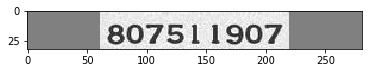

In [25]:
# sample_image = (sample_images + 0.5) * 255
plt.imshow((np.transpose(sample_images[0] + 0.5) * 255), cmap='gray', vmin=0, vmax=255)

In [29]:
str_decoded[0]

'807511907'

In [30]:
decoded_values

array([[24, 16, 23, 21, 17, 17, 25, 16, 23, -1, -1, -1, -1, -1, -1, -1],
       [21, 19, 17, 16, 20, 19, 21, 25, 23, 21, 19, 20, -1, -1, -1, -1],
       [52, 19, 25, 19, 24, 16, 17, 17, 21, 16, 17, -1, -1, -1, -1, -1],
       [16, 20, 21, 19, 21, 17, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [35, 17, 19, 17, 21, 16, 21, 17, 19, 25, 17, -1, -1, -1, -1, -1],
       [17, 25, 20, 21, 19, 21, 19, 21, 21, 20, -1, -1, -1, -1, -1, -1],
       [21, 17, 17, 23, 16, 21, 21, 20, -1, -1, -1, -1, -1, -1, -1, -1],
       [24, 24, 20, 19, 16, 20, 21, 17, 21, 25, 19, 25, 17, 16, -1, -1],
       [25, 16, 22, 17, 16, 23, 17, 21, 17, 21, 16, 21, -1, -1, -1, -1],
       [52, 19, 25, 19, 24, 16, 17, 17, 21, 16, 17, -1, -1, -1, -1, -1],
       [17, 25, 16, 17, 21, 17, 17, 17, -1, -1, -1, -1, -1, -1, -1, -1],
       [24, 17, 17, 22, 13, 20, 24, 17, 19, 21, -1, -1, -1, -1, -1, -1],
       [17, 19, 19, 16, 17, 21, 21, 17, 17, 17, 24, -1, -1, -1, -1, -1],
       [20, 24, 17, 20, 21, 25, 16, 17, 21, 20, -1,

In [27]:
str_decoded = []

for x in np.asarray(decoded_values):
    str_decoded.append(''.join([chr(val + FIRST_INDEX) for val in x if val != -1]))

In [28]:
str_decoded

['807511907',
 '531043597534',
 'T3938011501',
 '045351',
 'C1315051391',
 '1945353554',
 '51170554',
 '88430451593910',
 '906107151505',
 'T3938011501',
 '19015111',
 '8116-48135',
 '13301551118',
 '4814590154',
 '43922151505',
 'P161945',
 '851155907',
 '306113105',
 'D5103000',
 '09440',
 '26930491753907',
 '165011590',
 '6353015',
 '69253064',
 'A0750736253',
 '19330381313553',
 '601351215',
 'M9318253941',
 '0004560354515900',
 '1339711',
 '31790544',
 '35-35453935900']

In [85]:
str_original = ''.join([chr(x + FIRST_INDEX) for x in values])

In [86]:
str_original

'07530036113188511-3063854B63915551115-8160590719453535544623159001130110678907469531454P115810410753300450454694879746611-45350758P9051191659454191813041556353104359753401331554M06115904814590154190595454616955411639413811750150652692219076915890544546035-7115803021504955456553961604455554M1330451388111151'

In [46]:
img = cv2.imread('../data/samples/test.jpg', cv2.IMREAD_GRAYSCALE)

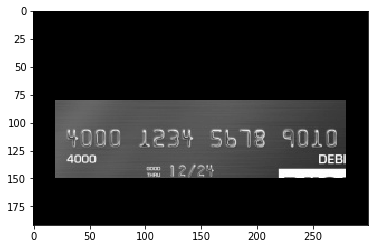

In [47]:
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

In [48]:
img_shape = img.shape
img = (img / 255) - 0.5

ratio = img_shape[0] / 32
img = img.reshape(int(img_shape[1] * ratio), 32)

In [49]:
feed = {
    inputs: np.expand_dims(img, 0),
}

decoded_values = sess.run(dense_decoded, feed_dict=feed)

In [52]:
str_decoded = []

for x in np.asarray(decoded_values):
    str_decoded.append(''.join([chr(val + FIRST_INDEX) for val in x if val != -1]))
    
str_decoded

['7B8B8B8B8B8B8B8B8B8B8B8B8B8B8B8B8B8B8B8B868B8B2B2B8B2BBBBB2BBBBBBB8B8B8B8B8B8B8B8B8B8B8']